# AI Algorithms Project - Option B
Gabriel SULTAN - Lalith Adithya CHANUMOLU - Jules WEJROCH - Alida Dovila ZOGO KANDA LONGMIS - DIA 6

<span style="color:red">! *Note : this notebook is self-contained, so no external report have been produced for this project* !</span>

#  Cost and Performance Optimization for Application Deployment and Scaling

**Problem Context and Motivation :** 
#
Modern Machine Learning models, especially in fields like Deep Learning, are becoming increasingly
large and complex and training these models on a single machine can take weeks or even months,creating a
significant bottleneck in the AI development cycle. To accelerate this process, companies use distributed
training, where the computational workload is spread across multiple machines in a cloud environment.
This approach can drastically reduce training time, but it introduces a major challenge: cost and
resource management.


The objective is to configure a training cluster that minimizes the total hourly infrastructure cost while ensuring that the training process is stable and efficient. 

# 1. Problem Formulation
(AI have been used for the formatting of mathematical formulas in this part)

**What is the formal definition of the application deployment problem?**

Find how many VMs to rent, how many identical service copies (replicas) to launch, and where to place them, so the system handles the workload without bottleneck, using enough CPU/RAM, while minimizing hourly cloud cost.

**Why is this problem computationally hard?**

This problem is computationally hard (NP-hard) because it requires finding the cheapest combination of up to 17 limited VM types from your dataset VM_Catalogue.xlsx, while also selecting integer replica counts for 4 components based on peak workload from Workload.xlsx, and determining a valid placement of replicas onto VMs.
The task resembles multidimensional knapsack and bin-packing/VM-placement, both NP-hard, where the number of possible configurations grows exponentially, making exhaustive search infeasible.

**What is the core intuition behind the approaches you developed?**

Our three methods leverage complementary ideas: Greedy rapidly selects VMs with the best cost per replica, Hill Climbing starts from an initial solution and iteratively refines it step by step, while Genetic Algorithm (GA) explores a population of solutions using mutation and crossover processes to escape local optima. Together, these methods combine speed, local search, and global optimization to address the VM placement problem effectively.

## 2.1. Sets and Indices

- **I** = {1, 2, 3, 4} : set of application components
- **J** : set of available virtual machine (VM) types
- **T** : set of time periods (if the problem is dynamic)

## 2.2. Parameters

For each component **i ∈ I** :
- **μᵢ** : service rate of component i (requests/second per replica)
- **λᵢ** : maximum arrival rate for component i (requests/second)
- **rᵢᵐⁱⁿ** : minimum number of replicas required for component i

For each VM type **j ∈ J** :
- **CPUⱼ** : number of CPUs available on a VM of type j
- **RAMⱼ** : amount of RAM available on a VM of type j (in GiB)
- **Costⱼ** : hourly cost of a VM of type j
- **Quantityⱼ** : maximum number of VMs of type j available
- **Rⱼ** : maximum number of replicas that a VM of type j can host
  - Rⱼ = min(CPUⱼ, ⌊RAMⱼ / 0.25⌋)

Global parameters :
- **CPU_req** = 1 : number of CPUs required per replica
- **RAM_req** = 0.25 : amount of RAM required per replica (in GiB)

## 2.3. Decision Variables

- **rᵢ** ∈ ℤ⁺ : number of replicas allocated to component i (i ∈ I)
- **xⱼ** ∈ ℤ⁺ : number of VMs of type j to deploy (j ∈ J)
- **yᵢⱼ** ∈ ℤ⁺ : number of replicas of component i placed on VMs of type j (optional, for explicit placement modeling)

## 2.4. Objective Function

Minimize the total hourly infrastructure cost :

$$\min Z = \sum_{j \in J} x_j \cdot \text{Cost}_j$$

## 2.5. Constraints

### 2.5.1. Service Stability

For each component i, the number of replicas must be sufficient to handle the maximum load :

$$r_i \cdot \mu_i \geq \lambda_i, \quad \forall i \in I$$

or equivalently :

$$r_i \geq \left\lceil \frac{\lambda_i}{\mu_i} \right\rceil = r_i^{min}, \quad \forall i \in I$$

### 2.5.2. CPU Resource Sufficiency

The total CPU capacity of the cluster must be at least equal to the total demand :

$$\sum_{j \in J} x_j \cdot \text{CPU}_j \geq \sum_{i \in I} r_i \cdot \text{CPU}_{req}$$

$$\sum_{j \in J} x_j \cdot \text{CPU}_j \geq \sum_{i \in I} r_i$$

### 2.5.3. RAM Resource Sufficiency

The total RAM capacity of the cluster must be at least equal to the total demand :

$$\sum_{j \in J} x_j \cdot \text{RAM}_j \geq \sum_{i \in I} r_i \cdot \text{RAM}_{req}$$

$$\sum_{j \in J} x_j \cdot \text{RAM}_j \geq 0.25 \cdot \sum_{i \in I} r_i$$

### 2.5.4. VM Availability

The number of VMs of each type cannot exceed the available quantity :

$$x_j \leq \text{Quantity}_j, \quad \forall j \in J$$

### 2.5.5. Valid Replica Placement

The total number of placed replicas cannot exceed the total capacity of the cluster :

$$\sum_{i \in I} r_i \leq \sum_{j \in J} x_j \cdot R_j$$

This constraint ensures that each VM can host at most Rⱼ replicas.

### 2.5.6. Domain Constraints

$$r_i \in \mathbb{Z}^+, \quad \forall i \in I$$
$$x_j \in \mathbb{Z}^+, \quad \forall j \in J$$

## 2.6. Model Summary

**Problem Type** : Integer Linear Program (ILP)

**Objective** : Cost minimization

**Complexity** : NP-hard (combinatorial optimization with integer variables)

**Possible Solution Methods** :
- Branch and Bound
- Heuristic algorithms (greedy, hill climbing, etc.)
- ILP solvers (CPLEX, Gurobi, OR-Tools)


# 2. Problem-Solving Approaches

## 2.1. Data Loading and Preprocessing


In [277]:
#import necessary librairies for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [278]:
#load as dataframes for easier manipulation
df_vm =pd.read_csv('VM_Catalogue.csv',sep=';')
df_workload = pd.read_csv('Workload.csv',sep=';')

In [279]:
#clean the dataframe
df_vm_clean= df_vm.copy()

df_vm_clean.columns = df_vm_clean.iloc[0] #set the first row as the header
df_vm_clean = df_vm_clean[1:].reset_index(drop=True) #drop the first row and reset the index

#convert to numeric values
df_vm_clean['CPU']=pd.to_numeric(df_vm_clean['CPU'])
df_vm_clean['RAM']= pd.to_numeric(df_vm_clean['RAM'])
df_vm_clean['Cost'] =pd.to_numeric(df_vm_clean['Cost'])
df_vm_clean['Quantity'] = pd.to_numeric(df_vm_clean['Quantity'])


In [280]:
#here we augment the dataframe with important columns we'll need later
#compute max replicas per VM
df_vm_clean['max_replicas'] = df_vm_clean.apply(
    lambda row: min(int(row['CPU'] // 1), int(row['RAM'] // 0.25)),
    axis=1)

# Compute cost per replicas
df_vm_clean['cost_per_replica'] = df_vm_clean['Cost'] / df_vm_clean['max_replicas']

print(df_vm_clean[['Type', 'CPU', 'RAM', 'Cost', 'Quantity', 'max_replicas', 'cost_per_replica']])


0  Type  CPU      RAM     Cost  Quantity  max_replicas  cost_per_replica
0   T00    1     3.75   0.1914        10             1          0.191400
1   T01    2     1.80   0.2104        10             2          0.105200
2   T02    2     7.50   0.2684        10             2          0.134200
3   T03    2    13.00   0.2944        10             2          0.147200
4   T04    4     3.60   0.3064        10             4          0.076600
5   T05    4    15.00   0.4224        10             4          0.105600
6   T06    4    26.00   0.4744        10             4          0.118600
7   T07    8     7.20   0.4984        10             8          0.062300
8   T08    8    30.00   0.7304        10             8          0.091300
9   T09    8    52.00   0.8344        10             8          0.104300
10  T10   16    14.40   0.8824        10            16          0.055150
11  T11   16    60.00   1.3464        10            16          0.084150
12  T12   16   104.00   1.5544        10           

In [281]:
#service rates per component (μ) as given in the project statement
mu ={1: 1416, 2:696, 3:1005,4:1259}

In [282]:

# Peak workload (λ_max)
peak_workload = df_workload['input_rate'].max()
print(f"peak workload : {peak_workload}")

#Find the minimum replicas for each component (r_min)
r_min={}
for comp_id,mu_c in mu.items():
    r_min[comp_id] =int(np.ceil(peak_workload /mu_c)) #compute it

for comp_id in sorted(r_min.keys()):
    print(f"Component {comp_id}: r_min = {r_min[comp_id]} (μ={mu[comp_id]})")#display it



#total minimum replicas needed
total_min_replicas = sum(r_min.values())
print(f"\nTotal minimum replicas needed: {total_min_replicas}")


peak workload : 5751
Component 1: r_min = 5 (μ=1416)
Component 2: r_min = 9 (μ=696)
Component 3: r_min = 6 (μ=1005)
Component 4: r_min = 5 (μ=1259)

Total minimum replicas needed: 25


## 2.2. Algorithm Designs

We will implement three algorithms to solve the optimization problem:

1. **Greedy Algorithm** - Cost per replica based selection
2. **Hill Climbing** - Local search optimization with restart
3. **Genetic Algorithm (GA)** - Evolutionary approach for global search

### Algorithm Selection Rationale

**Greedy Algorithm**: We chose the greedy approach as a fast baseline method that prioritizes VM types with the lowest cost per replica. This strategy is intuitive for cost minimization problems and provides a quick, deterministic solution. The greedy algorithm serves as both a standalone solution and an excellent starting point for more sophisticated methods, making it ideal for real-time optimization scenarios where speed is critical.

**Hill Climbing**: We selected Hill Climbing to iteratively improve upon initial solutions through local search. Unlike greedy methods that make irreversible decisions, Hill Climbing explores the neighborhood of solutions by adding, removing, or swapping VMs, allowing it to refine configurations. The multiple restart mechanism helps escape local optima, making it well-suited for finding better solutions when computational time permits. This approach balances solution quality with reasonable execution time.

**Genetic Algorithm (GA)**: We introduced a Genetic Algorithm as a population-based metaheuristic to explore a wider solution space and avoid poor local minima (probleme we have with hill climbing). GA combines selection, crossover, and mutation to evolve increasingly effective VM allocations over multiple generations. This approach is particularly suitable when the problem landscape is complex or highly constrained, providing robustness and the potential to discover high-quality solutions that greedy or local search methods might miss.


In [283]:
#Base class for VM optimization algorithms that will help us implement our algorithms
class VMOptimizer:    


    #initialize the class and take all the parameters needed
    def __init__(self, vm_df, r_min_dict, mu_dict): 
        
        self.vm_df = vm_df.copy()
        self.r_min = r_min_dict
        self.mu = mu_dict
        self.components = sorted(r_min_dict.keys())
        self.vm_types = list(range(len(vm_df)))
        
        #get all the VM's parameters
        self.vm_cpu = vm_df['CPU'].values
        self.vm_ram = vm_df['RAM'].values
        self.vm_cost = vm_df['Cost'].values
        self.vm_quantity = vm_df['Quantity'].values
        self.vm_max_replicas = vm_df['max_replicas'].values
        
    def calculate_cost(self, x):
        #return the total cost for VM allocation x
        return np.sum(x*self.vm_cost) #basically sum the cost of all the VMs in x
    
    def check_constraints(self, r, x):
        #Check if solution (r, x) satisfies all constraints


        #stability: ri >= r_min[i]
        for i, comp_id in enumerate(self.components):
            if r[comp_id] < self.r_min[comp_id]:
                return False
        
        #CPU sufficiency
        total_cpu= np.sum(x * self.vm_cpu)
        total_replicas = sum(r.values())
        if total_cpu < total_replicas: #here the contraint
            return False
        
        # RAM sufficiency
        total_ram =np.sum(x * self.vm_ram)
        if total_ram < 0.25 * total_replicas:
            return False
        
        #VM availability, quantity check
        for j in range(len(x)):
            if x[j] > self.vm_quantity[j]:
                return False
        
        #valid placement
        total_capacity=np.sum(x*self.vm_max_replicas)
        if total_replicas> total_capacity :
            return False
        
        
        return True,"all the constraints are satisfied !"
    
    def get_resource_utilization(self, r, x):
        #extra metrics on the resources used 

        total_replicas=sum(r.values())
        total_cpu=np.sum(x *self.vm_cpu)
        total_ram= np.sum(x*self.vm_ram)
        total_capacity=np.sum(x*self.vm_max_replicas)


        
        return {
            'cpu_utilization': total_replicas /total_cpu if total_cpu >0 else 0,
            'ram_utilization':(0.25*total_replicas) /total_ram if total_ram>0 else 0,
            'capacity_utilization': total_replicas/total_capacity if total_capacity>0 else 0}


In [284]:
#Greedy algorithm: selecting VMs based on cost per replica efficiency
class GreedyOptimizer(VMOptimizer):
    
    def solve(self): #here is the greedy approach
        
        #sorting VM by cost per replica 
        sorted_vms=self.vm_df.sort_values('cost_per_replica').reset_index(drop= True)
        

        #initialize
        x =np.zeros(len(self.vm_df), dtype=int)#initializing the vector of VMs
        r = {comp_id: self.r_min[comp_id] for comp_id in self.components}#initializing the vector of replicas
        total_replicas = sum(r.values())#total replicas needed
        


        #track allocated resources
        allocated_cpu=0
        allocated_ram=0
        allocated_capacity= 0
        
        # greedily add VMs until constraints are satisfied
        for idx, row in sorted_vms.iterrows(): #iterating over the sorted VMs
            vm_idx = self.vm_df.index[self.vm_df['Type'] == row['Type']].tolist()[0] #getting the index of the VM
            max_to_add = int(row['Quantity']) #getting the max quantity of the VM
            
            while (allocated_cpu < total_replicas or 
                   allocated_ram < 0.25 * total_replicas or
                   allocated_capacity < total_replicas) and x[vm_idx] < max_to_add: 
                   #while the constraints are not satisfied and the VM is not at its max
                x[vm_idx] += 1
                allocated_cpu += row['CPU']
                allocated_ram += row['RAM']
                allocated_capacity += row['max_replicas']
        
        #verify and return solution
        is_valid, message = self.check_constraints(r, x)
        cost = self.calculate_cost(x)
        
        
        return {
            'r': r,
            'x': x,
            'cost': cost,
            'valid': is_valid,
            'message': message,
            'utilization':self.get_resource_utilization(r, x)}

In [285]:
#Hill climbing algorithm with random restart for VM optimization
class HillClimbingOptimizer(VMOptimizer):
    
    #initialize the class
    def __init__(self, vm_df,r_min_dict,mu_dict, max_iterations = 1000, 
                 max_stagnation= 50,num_restarts=5, stochastic_prob=0.1): #parameters for hill climbing algo
    
        super().__init__(vm_df, r_min_dict, mu_dict)
        #parameters for hill climbing algo
        self.max_iterations=max_iterations 
        self.max_stagnation= max_stagnation
        self.num_restarts =num_restarts
        self.stochastic_prob = stochastic_prob
        
        #sort VM by cost per replica for smart neighbor generation
        self.sorted_vm_indices=vm_df.sort_values('cost_per_replica').index.tolist()
    
    def repair_solution(self,x,r):
        #this function repairs an invalid solution to make it feasible


        x_rep=x.copy()
        r_rep={k: v for k, v in r.items()}
        
        # make sure minimum replicas 
        for comp_id in self.components:
            r_rep[comp_id] =max(r_rep[comp_id], self.r_min[comp_id]) 
        
        total_replicas=sum(r_rep.values()) #total replicas needed
        
        #compute current resources
        total_cpu = np.sum(x_rep * self.vm_cpu)
        total_ram = np.sum(x_rep * self.vm_ram)
        total_capacity = np.sum(x_rep * self.vm_max_replicas)
        
        #Add VMs if resources are insufficient (prefer cheaper VMs)
        while (total_cpu<total_replicas or total_ram <  0.25 * total_replicas or total_capacity < total_replicas): 
            #while the constraints are not satisfied
            added =False

            for vm_idx in self.sorted_vm_indices : #iterating over the sorted VMs

                if x_rep[vm_idx] < self.vm_quantity[vm_idx]: #quantity check
                    x_rep[vm_idx] += 1 #adding a VM
                    total_cpu += self.vm_cpu[vm_idx]
                    total_ram += self.vm_ram[vm_idx]
                    total_capacity += self.vm_max_replicas[vm_idx]
                    added =True
                    break

            if not added:
                break
        
        #remove excess VMs (optimize cost)
        for vm_idx in reversed(self.sorted_vm_indices): #iterating over the sorted VMs in reverse
            if x_rep[vm_idx] > 0: 
                x_test = x_rep.copy()
                x_test[vm_idx] -=1

                total_cpu_test = np.sum(x_test * self.vm_cpu)
                total_ram_test = np.sum(x_test * self.vm_ram)
                total_capacity_test = np.sum(x_test * self.vm_max_replicas)
                

                if (total_cpu_test >= total_replicas and total_ram_test >= 0.25 * total_replicas and total_capacity_test >= total_replicas) :
                    #if the constraints are satisfied
                    x_rep = x_test
                    total_cpu =total_cpu_test
                    total_ram=total_ram_test
                    total_capacity=total_capacity_test
        
        return x_rep, r_rep #return the repaired solution
    
    def generate_neighbors(self, x, r): 
        #now we can generate the neighbors

        neighbors=[]
        
        #add VM (cheaper ones)
        for vm_idx in self.sorted_vm_indices[:10] :  
            #we try the top 10 cheapest
            if x[vm_idx] <self.vm_quantity[vm_idx]: #if the VM is not at its max
                x_new =x.copy()
                x_new[vm_idx]+= 1
                x_new, r_new =self.repair_solution(x_new, r)

                if self.check_constraints(r_new, x_new)[0]: #check constraints
                    neighbors.append((x_new, r_new)) #add the neighbor to the list
        
        #remove VM (expensive ones)
        used_vms= [i for i in range(len(x)) if x[i] > 0] #getting the indices of the VMs that are used
        used_vms_sorted = sorted(used_vms, key=lambda i: self.vm_cost[i], reverse=True)#sorting them by cost
        for vm_idx in used_vms_sorted[:10]:  #we try the top 10 most expensive
            x_new = x.copy()
            x_new[vm_idx] -=1
            x_new, r_new=self.repair_solution(x_new, r)#call the repair function

            if self.check_constraints(r_new, x_new)[0]: 
                neighbors.append((x_new, r_new)) 
        
        #Swap VM by removing expensive and adding cheaper
        for vm_remove in used_vms_sorted[:5]: #iterating over the top 5 most expensive VMs
            for vm_add in self.sorted_vm_indices[:5]: #iterating over the top 5 cheapest VMs
                if x[vm_remove] > 0 and x[vm_add] < self.vm_quantity[vm_add]: 
                    x_new = x.copy()
                    x_new[vm_remove] -=1
                    x_new[vm_add]+=1
                    x_new, r_new =self.repair_solution(x_new, r)

                    if self.check_constraints(r_new, x_new)[0]:
                        neighbors.append((x_new, r_new))
        
        #change replica count
        for comp_id in self.components:
            #increase
            r_new = {k: v for k, v in r.items()}#copying the replicas
            r_new[comp_id] += 1#increasing the replica count
            x_new, r_new = self.repair_solution(x, r_new)

            if self.check_constraints(r_new, x_new)[0]:
                neighbors.append((x_new, r_new))
            
            #decrease
            if r[comp_id] > self.r_min[comp_id]: #if above minimum
                r_new = {k: v for k, v in r.items()}
                r_new[comp_id] -= 1
                x_new, r_new = self.repair_solution(x, r_new)

                if self.check_constraints(r_new, x_new)[0]:
                    neighbors.append((x_new, r_new))
        
        return neighbors 
    
    
    def create_initial_solution(self, use_greedy=False): 
        #now we can create the initial solution
       
        if use_greedy: #we'll use the greedy for the first restart as it is already a good solution
            greedy=GreedyOptimizer(self.vm_df,self.r_min,self.mu)
            solution =greedy.solve()
            return solution['x'].copy(), solution['r'].copy() #return initial solution
            
        #now we want random solutions for following restarts to explore different parts of the search space
        r ={comp_id: self.r_min[comp_id] for comp_id in self.components} #initializing the replicas
        x = np.zeros(len(self.vm_df), dtype=int) #initializing the VMs
        total_replicas = sum(r.values()) #total replicas needed
        
        # Add VMs randomly until constraints are satisfied
        vm_weights=[1.0 / (self.vm_df.iloc[i]['cost_per_replica'] + 0.01) for i in range(len(self.vm_df))] 
        vm_weights = np.array(vm_weights)#converting to array
        vm_weights = vm_weights / vm_weights.sum() #normalizing
        
        while True:

            vm_idx =np.random.choice(len(x),p=vm_weights)#choosing a VM randomly

            if x[vm_idx]<self.vm_quantity[vm_idx]: #if the VM is not at its max
                x[vm_idx]+= 1 #adding a VM

                total_cpu=np.sum(x * self.vm_cpu) #updating the total CPU
                total_ram=np.sum(x * self.vm_ram) #updating the total RAM
                total_capacity=np.sum(x * self.vm_max_replicas)
                
                if (total_cpu >= total_replicas and total_ram >= 0.25 * total_replicas and total_capacity >= total_replicas):
                    break #make sureconstraints are satisfied
        
        x, r =self.repair_solution(x, r) #repair the solution
        return x,r
    
    def hill_climb(self, x_start, r_start, verbose=False):
        #now we can perform the hill climbing
        x_current =x_start.copy()#copying the current solution
        r_current = {k: v for k, v in r_start.items()}#copying the replicas
        cost_current = self.calculate_cost(x_current)# cost of the current solution
        
        best_x =x_current.copy()#copying the best solution
        best_r = {k: v for k, v in r_current.items()}#copying the best replicas
        best_cost = cost_current#copying the best cost
        

        stagnation= 0#initialising the stagnation
        iteration= 0#initializing the iteration
        history=[]#initializing the history
        

        while iteration < self.max_iterations and stagnation < self.max_stagnation:
            neighbors = self.generate_neighbors(x_current, r_current)#call generate the neighbors
            
            
            #evaluate all neighbors
            neighbor_costs =[self.calculate_cost(x) for x,r in neighbors]
            best_neighbor_idx=np.argmin(neighbor_costs)#getting the index of the best neighbor
            best_neighbor_cost = neighbor_costs[best_neighbor_idx]#his cost
            
            #Accept if better or with small probability if worse (stochastic)
            if best_neighbor_cost<cost_current:
                x_current,r_current = neighbors[best_neighbor_idx]
                cost_current = best_neighbor_cost
                stagnation=0
                
                if cost_current<best_cost:
                    best_x=x_current.copy()
                    best_r = {k: v for k, v in r_current.items()}
                    best_cost = cost_current
            elif random.random() < self.stochastic_prob:
                #stochastic acceptance of worse solution
                x_current,r_current =neighbors[best_neighbor_idx] #updating the current solution
                cost_current = best_neighbor_cost#updating the cost
                stagnation += 1
            else:
                stagnation += 1
            
            iteration +=1
            history.append({'iteration': iteration, 'cost': best_cost})#appending the history
        
        return best_x,best_r,best_cost,history #return the best solution
    
    def solve(self, verbose=False):
        #now we can solve the problem with multiple restarts
        
        best_x = None
        best_r  = None
        best_cost =np.inf
        all_history =[]
        
        for restart in range(self.num_restarts):
            
            #greedy for first restart, random for others
            use_greedy =(restart == 0)
            x_start,r_start=self.create_initial_solution(use_greedy=use_greedy)
            
            x_sol, r_sol, cost_sol, history =self.hill_climb(x_start, r_start, verbose=False) #call the hill climbing
            
            #update history with restart info
            for h in history:
                h['restart'] = restart+ 1
                h['iteration']=h['iteration'] + restart*self.max_iterations

            all_history.extend(history)
            


            if cost_sol<best_cost :
                best_x =x_sol
                best_r= r_sol
                best_cost=cost_sol
            
            if verbose: #verbose to track progress 
                print(f"Best cost: ${best_cost:.4f}")
        
        is_valid, message = self.check_constraints(best_r, best_x)
        
        return {
            'r': best_r,
            'x': best_x,
            'cost': best_cost,
            'valid': is_valid,
            'message': message,
            'utilization': self.get_resource_utilization(best_r, best_x),
            'history': all_history} #final return



More details for the Genetic Algorithm (GA)

- **Encoding Strategy** :
We use a **direct integer encoding** where each chromosome is a vector `x` of length `n_vm_types`, where `x[j]` represents the number of VMs of type `j` to deploy. This encoding is natural for our problem as it directly maps to the decision variables. The replica allocation `r` is fixed to the minimum required (`r_min`) to ensure feasibility and simplify the search space.

- **Fitness Function** :
The fitness function is the **total hourly infrastructure cost** to minimize:
$$f(x) = \sum_{j \in J} x_j \cdot \text{Cost}_j$$
Lower fitness values indicate better solutions. Invalid solutions (violating constraints) are penalized with a very high cost to discourage their selection.

- **Selection Method with Elitism** :
We use **tournament selection** where `k` individuals are randomly chosen and the best one is selected as a parent. This balances exploration and exploitation.
**Elitism** ensures that the top `elite_size` individuals from the current generation are directly copied to the next generation, preventing the loss of good solutions.

- **Crossover Method** :
We implement **uniform crossover**: for each VM type position, we randomly choose the allocation from either parent with equal probability. This allows mixing of different allocation patterns while maintaining diversity.

- **Mutation Method** :
Mutation randomly modifies a solution with probability `mutation_rate`:
1. Add mutation: Increase the count of a randomly selected VM type (if not at maximum quantity) 
2. Remove mutation: Decrease the count of a randomly selected VM type (if currently used)
After mutation, a **repair function** ensures the solution remains feasible.

- **Replacement Strategy** :
We use **generational replacement with elitism**: the new generation entirely replaces the old one, except for the elite individuals that are preserved. This ensures monotonic improvement of the best solution while allowing population diversity through new offspring.


In [286]:
#genetic Algorithm
class GeneticAlgorithmOptimizer(VMOptimizer):
    
    def __init__(self, vm_df,r_min_dict, mu_dict,population_size=50,generations=100,
                 mutation_rate=0.2,crossover_rate=0.8, tournament_size=3, elite_size= 2):
        super().__init__(vm_df,r_min_dict, mu_dict)
        self.population_size = population_size
        self.generations=generations
        self.mutation_rate=mutation_rate
        self.crossover_rate =crossover_rate
        self.tournament_size = tournament_size
        self.elite_size = elite_size  #number of elite individuals to preserve
        self.sorted_vm_indices =vm_df.sort_values('cost_per_replica').index.tolist()
    
    def repair_solution(self, x):#Repair an invalid solution to make it feasible
        x_rep =x.copy()
        r={comp_id:self.r_min[comp_id] for comp_id in self.components}
        total_replicas=sum(r.values())
        
        #compute current resources
        total_cpu=np.sum(x_rep *self.vm_cpu)
        total_ram=np.sum(x_rep *self.vm_ram)
        total_capacity= np.sum(x_rep *self.vm_max_replicas)
        
        #Add VMs if resources are insufficient (prefer cheaper VMs)
        while (total_cpu <total_replicas or total_ram <0.25*total_replicas or total_capacity < total_replicas) :
            added =False
            for vm_idx in self.sorted_vm_indices :

                if x_rep[vm_idx]<self.vm_quantity[vm_idx] :
                    x_rep[vm_idx]+= 1
                    total_cpu +=self.vm_cpu[vm_idx]
                    total_ram +=self.vm_ram[vm_idx]
                    total_capacity += self.vm_max_replicas[vm_idx]
                    added =True

                    break

            if not added:
                break
        
        #remove excess VMs (optimize cost) - remove expensive ones first
        for vm_idx in reversed(self.sorted_vm_indices):
            
            while x_rep[vm_idx] >0:
                x_test =x_rep.copy()
                x_test[vm_idx] -= 1
                total_cpu_test =np.sum(x_test* self.vm_cpu)
                total_ram_test =np.sum(x_test* self.vm_ram)
                total_capacity_test = np.sum(x_test * self.vm_max_replicas)
                if (total_cpu_test >=total_replicas and total_ram_test >= 0.25 * total_replicas 

                    and total_capacity_test>= total_replicas) :
                    x_rep =x_test
                    total_cpu, total_ram, total_capacity = total_cpu_test, total_ram_test, total_capacity_test

                else:
                    break

        return x_rep
    
    def fitness(self, x): #Compute fitness (cost) for a chromosome. Lower is better.

        r ={comp_id: self.r_min[comp_id] for comp_id in self.components}
        result =self.check_constraints(r, x)
        #check_constraints returns F=false or true, message
        is_valid =result[0] if isinstance(result , tuple) else result
        if not is_valid :
            return float('inf') #penalize invalid solutions
        return self.calculate_cost(x)
    
    def create_random_individual(self):#create a random feasible individual
        
        x =np.zeros(len(self.vm_df) , dtype=int) 
        r={comp_id : self.r_min[comp_id] for comp_id in self.components}
        total_replicas =sum(r.values())
        
        #randomly add VMs with bias towards cost-efficient ones
        vm_weights=np.array([1.0/ (self.vm_df.iloc[i]['cost_per_replica' ] + 0.01) for i in range( len(self.vm_df))])
        vm_weights = vm_weights /vm_weights.sum()
        
        while True :

            vm_idx=np.random.choice(len(x), p = vm_weights)
            if x[vm_idx]< self.vm_quantity[vm_idx]:
                x[vm_idx]+= 1
                total_cpu = np.sum(x * self.vm_cpu)
                total_ram = np.sum(x * self.vm_ram)
                total_capacity = np.sum(x * self.vm_max_replicas)
                if (total_cpu>=total_replicas and total_ram >=0.25 *total_replicas and total_capacity >=total_replicas) :
                    break

        return self.repair_solution(x)
    
    def initialize_population(self): #initialize population with random individuals + greedy solution
        
        population = []
        # adding greedy solution as a good starting point
        greedy = GreedyOptimizer(self.vm_df,self.r_min, self.mu)
        greedy_result = greedy.solve()
        population.append(greedy_result['x'].copy())
        #fill rest with random individuals
        for _ in range(self.population_size -1) :
            population.append(self.create_random_individual())

        return population
    

    def tournament_selection(self, population, fitnesses):#select an individual using tournament selection
        
        tournament_indices =np.random.choice(len(population) , size= self.tournament_size,replace = False)
        tournament_fitnesses=[fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices [np.argmin(tournament_fitnesses)]
        return population[winner_idx].copy()
    

    def elitism(self, population, fitnesses):#keep the best individuals to preserve at each generation
    
        sorted_indices =np.argsort(fitnesses)
        elite=[population[i].copy() for i  in sorted_indices[ :self.elite_size]]

        return elite
    
    def crossover(self, parent1, parent2):# Uniform crossover: randomly choose from each parent for each gene
        if random.random()>self.crossover_rate :

            return parent1.copy(), parent2.copy()

        child1=np.zeros_like(parent1)
        child2=np.zeros_like(parent2)
        for i in range(len(parent1)) :
            if random.random() < 0.5:
                child1[i], child2[i] =parent1[i],parent2[i]
            else:
                child1[i], child2[i] =parent2[i],parent1[i]

        return child1, child2
    
    def mutate(self, individual):#randomly add or remove VMs
        
        if random.random()> self.mutation_rate:
            return individual
        mutant =individual.copy()
        mutation_type =random.choice(['add', 'remove', 'swap']) #select a move
        
        if mutation_type =='add':
            #Add a VM of a random type
            vm_idx =random.choice(self.sorted_vm_indices[:10])  #prefer cheaper VMs
            if mutant[vm_idx] <self.vm_quantity [vm_idx]:
                mutant[vm_idx] += 1
        elif mutation_type=='remove':
            #remove a VM from used types
            used_vms= [i for i in range(len(mutant)) if mutant[i]> 0]
            if used_vms :
                vm_idx =random.choice(used_vms)
                mutant[vm_idx]-=1
        else:  # swap
            #swap: remove expensive, add cheaper
            used_vms =[i for i in range(len(mutant)) if mutant[i] >0]
            if used_vms :
                vm_remove =max(used_vms,key=lambda i:self.vm_cost[i] )
                vm_add = random.choice( self.sorted_vm_indices[:5] )
                if mutant[vm_remove] > 0 and mutant[vm_add] <self.vm_quantity[vm_add]:
                    mutant[vm_remove]-=1
                    mutant[vm_add]+=1

        return self.repair_solution(mutant)
    
    def solve(self, verbose=False): #to run
        
        population =self.initialize_population() #furst: initialize
        best_x, best_cost=None, float('inf')
        history=[]
        
        for gen in range(self.generations):
            # evaluate fitness for all individuals
            fitnesses =[self.fitness(ind) for ind in population]
            
            #track best solution
            gen_best_idx =np.argmin(fitnesses )
            if fitnesses[gen_best_idx]<best_cost:
                best_cost =fitnesses[gen_best_idx]
                best_x=population[gen_best_idx].copy()
            history.append({'generation':gen + 1, 'best_cost':best_cost, 'avg_cost':np.mean([f for f in fitnesses if f<float('inf')])} )
            
            # Elitism: preserve best individuals
            new_population = self.elitism(population, fitnesses)
            
            # Generate offspring to fill the rest of the population
            while len(new_population)<self.population_size :

                parent1=self.tournament_selection(population, fitnesses)
                parent2=self.tournament_selection(population, fitnesses)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                new_population.append(child1)
                if len(new_population)<self.population_size :
                    new_population.append(child2)
            
            #replacement: new generation replaces old
            population = new_population
            
        
        
        #Final result
        r ={comp_id: self.r_min[comp_id] for comp_id in self.components}
        is_valid , message= self.check_constraints(r,best_x)
        
        return {
            'r' : r,
            'x': best_x ,
            'cost':best_cost ,
            'valid':is_valid ,
            'message':message,
            'utilization':self.get_resource_utilization(r, best_x),
            'history': history}


# 3. Evaluation 

This section provides a comprehensive empirical evaluation of our two optimization approaches: the Greedy Algorithm and Hill Climbing. We analyze their performance across multiple dimensions including solution quality, computational efficiency, resource utilization, and scalability.


## 3.1. Direct Comparison of Approaches

We begin by comparing the two algorithms on the baseline problem instance to establish their relative strengths and weaknesses.


In [287]:


results = {}

#Greedy Algorithm
print("\n1. Greedy Algorithm")

#runing greedy
greedy = GreedyOptimizer(df_vm_clean, r_min, mu)
start_time=time.time()
greedy_result=greedy.solve()
greedy_time =time.time() - start_time
results['Greedy']= greedy_result
results['Greedy']['time']=greedy_time

print(f"Cost:${greedy_result['cost']:.4f}/hour")
print(f"Time: {greedy_time:.4f} seconds")

#Hill Climbing
print("\n2. Hill Climbing")

#runing hill
hc=HillClimbingOptimizer(df_vm_clean, r_min, mu, max_iterations=500, max_stagnation=50, num_restarts=5, stochastic_prob=0.1)
start_time = time.time()
hc_result = hc.solve(verbose=False)
hc_time =time.time() - start_time
results['Hill Climbing']= hc_result
results['Hill Climbing']['time'] = hc_time


print(f"Cost: ${hc_result['cost']:.4f}/hour")
print(f"Time: {hc_time:.4f}seconds")

#Genetic Algorithm
print("\n3. Genetic Algorithm")

#running GA
ga =GeneticAlgorithmOptimizer(df_vm_clean, r_min, mu,population_size=50, generations = 100,mutation_rate=0.2, crossover_rate=0.8, tournament_size= 3,elite_size=2)
start_time =time.time()
ga_result =ga.solve(verbose=False)
ga_time= time.time()-start_time
results['Genetic Algorithm'] = ga_result
results['Genetic Algorithm']['time'] = ga_time

print(f"Cost: ${ga_result['cost']:.4f}/hour")
print(f"Time: {ga_time:.4f} seconds")



1. Greedy Algorithm
Cost:$1.7648/hour
Time: 0.0026 seconds

2. Hill Climbing
Cost: $1.7648/hour
Time: 0.2415seconds

3. Genetic Algorithm
Cost: $1.7648/hour
Time: 0.1894 seconds


In [288]:
# Create comprehensive comparison table with more metrics
from matplotlib.cbook import print_cycles
import pandas as pd

comparison_data ={
    'Metric': [
        'Total Cost ($/hour)',
        'Execution Time (seconds)',
        'CPU Utilization (%)',
        'RAM Utilization (%)',
        'Capacity Utilization (%)',
        'Cost Improvement vs Greedy (%)',
        'Time Ratio (vs Greedy)',
        'Solution Validity'
    ],
    'Greedy Algorithm': [
        f"${results['Greedy']['cost']:.4f}",
        f"{results['Greedy']['time']:.4f}",
        f"{results['Greedy']['utilization']['cpu_utilization']*100:.2f}",
        f"{results['Greedy']['utilization']['ram_utilization']*100:.2f}",
        f"{results['Greedy']['utilization']['capacity_utilization']*100:.2f}",
        "0.00% (baseline)",
        "1.00x",
        "✓ Valid"],
    'Hill Climbing': [
        f"${results['Hill Climbing']['cost']:.4f}",
        f"{results['Hill Climbing']['time']:.4f}",
        f"{results['Hill Climbing']['utilization']['cpu_utilization']*100:.2f}",
        f"{results['Hill Climbing']['utilization']['ram_utilization']*100:.2f}",
        f"{results['Hill Climbing']['utilization']['capacity_utilization']*100:.2f}",
        f"{(1 - results['Hill Climbing']['cost']/results['Greedy']['cost'])*100:.2f}%",
        f"{results['Hill Climbing']['time']/results['Greedy']['time']:.1f}x",
        "✓ Valid"],
    'Genetic Algorithm':[
        f"${results['Genetic Algorithm']['cost']:.4f}",
        f"{results['Genetic Algorithm']['time']:.4f}",
        f"{results['Genetic Algorithm']['utilization']['cpu_utilization']*100:.2f}",
        f"{results['Genetic Algorithm']['utilization']['ram_utilization']*100:.2f}",
        f"{results['Genetic Algorithm']['utilization']['capacity_utilization']*100:.2f}",
        f"{(1 - results['Genetic Algorithm']['cost']/results['Greedy']['cost'])*100:.2f}%",
        f"{results['Genetic Algorithm']['time']/results['Greedy']['time']:.1f}x",
        "✓ Valid"]
}

comparison_df =pd.DataFrame(comparison_data) #convert to dataframe for easier print

print("DETAILED ALGORITHM COMPARISON")
print("-"*60)
print(comparison_df.to_string(index=False))



DETAILED ALGORITHM COMPARISON
------------------------------------------------------------
                        Metric Greedy Algorithm Hill Climbing Genetic Algorithm
           Total Cost ($/hour)          $1.7648       $1.7648           $1.7648
      Execution Time (seconds)           0.0026        0.2415            0.1894
           CPU Utilization (%)            78.12         78.12             78.12
           RAM Utilization (%)            21.70         21.70             21.70
      Capacity Utilization (%)            78.12         78.12             78.12
Cost Improvement vs Greedy (%) 0.00% (baseline)         0.00%             0.00%
        Time Ratio (vs Greedy)            1.00x         93.0x             72.9x
             Solution Validity          ✓ Valid       ✓ Valid           ✓ Valid


In [289]:
#detailed solution breakdown

print("DETAILED SOLUTION BREAKDOWN")
print("=" * 60)

print("\n1. GREEDY ALGORITHM SOLUTION:")
print("-" * 60)

greedy_x =results['Greedy']['x']
greedy_r=results['Greedy']['r']
print(f"Replica Allocation: {greedy_r}") #shows replica allocation
print(f"Total Replicas: {sum(greedy_r.values())}")#shows total replicas
print("\nVM Allocation:") 
for i,count in enumerate(greedy_x):#how the price per hour is comput
    if count >0 :
        vm_type=df_vm_clean.iloc[i]['Type']
        vm_cost= df_vm_clean.iloc[i]['Cost']
        print(f" {vm_type}: {int(count)} VMs × ${vm_cost:.4f} ={count * vm_cost:.4f}$/hour")

print("\n2. HILL CLIMBING SOLUTION:")
print("-" * 60)

hc_x =results['Hill Climbing']['x']
hc_r=results['Hill Climbing']['r']
print(f"Replica Allocation: {hc_r}")
print(f"Total Replicas: {sum(hc_r.values())}")
print("\nVM Allocation:")
for i, count in enumerate(hc_x):
    if count>0 :
        vm_type = df_vm_clean.iloc[i]['Type']
        vm_cost = df_vm_clean.iloc[i]['Cost']
        print(f" {vm_type}: {int(count)} VMs × ${vm_cost:.4f} = {count * vm_cost:.4f}$/hour")



print("\n3. GENETIC ALGORITHM SOLUTION:")
print("-" * 60)

ga_x=results['Genetic Algorithm']['x']
ga_r =results['Genetic Algorithm']['r']
print(f"Replica Allocation: {ga_r}")
print(f"Total Replicas: {sum(ga_r.values())}")
print("\nVM Allocation:")
for i,count in enumerate(ga_x):
    if count>0 :
        vm_type =df_vm_clean.iloc[i]['Type']
        vm_cost=df_vm_clean.iloc[i]['Cost']
        print(f"{vm_type}: {int(count)} VMs × ${vm_cost:.4f} = {count * vm_cost:.4f}$/hour")


DETAILED SOLUTION BREAKDOWN

1. GREEDY ALGORITHM SOLUTION:
------------------------------------------------------------
Replica Allocation: {1: 5, 2: 9, 3: 6, 4: 5}
Total Replicas: 25

VM Allocation:
 T10: 2 VMs × $0.8824 =1.7648$/hour

2. HILL CLIMBING SOLUTION:
------------------------------------------------------------
Replica Allocation: {1: 5, 2: 9, 3: 6, 4: 5}
Total Replicas: 25

VM Allocation:
 T10: 2 VMs × $0.8824 = 1.7648$/hour

3. GENETIC ALGORITHM SOLUTION:
------------------------------------------------------------
Replica Allocation: {1: 5, 2: 9, 3: 6, 4: 5}
Total Replicas: 25

VM Allocation:
T10: 2 VMs × $0.8824 = 1.7648$/hour


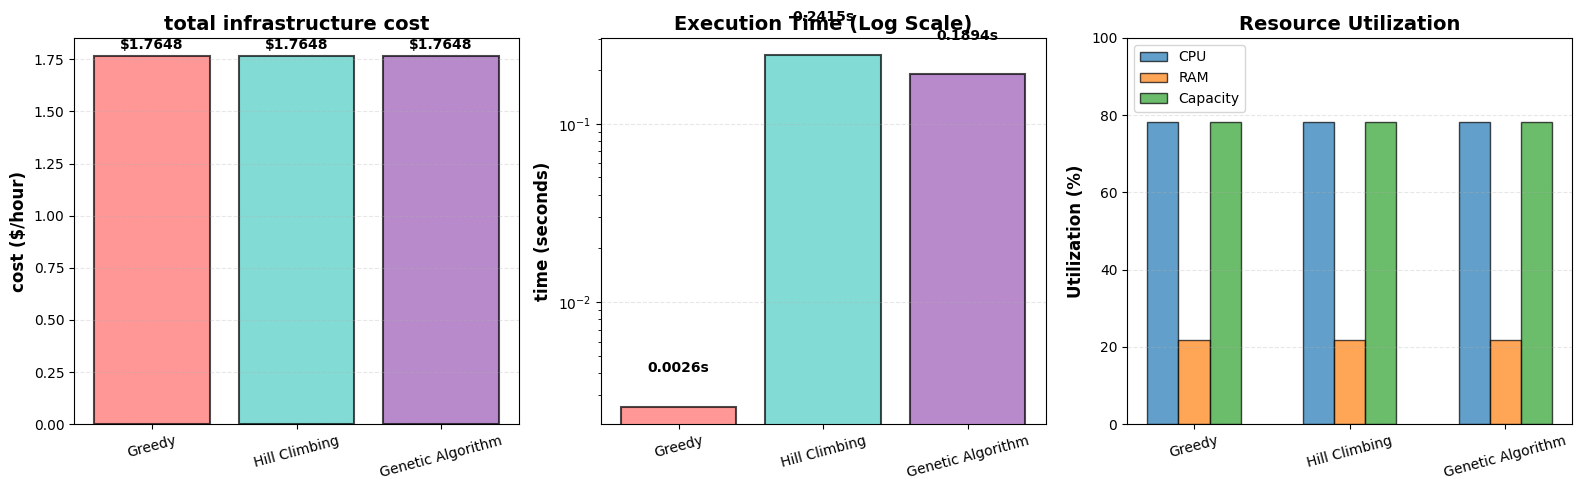

In [290]:
# Visualization: Cost and Time Comparison
fig,axes=plt.subplots(1, 3,figsize= (16, 5))

#Cost comparison
algorithms =['Greedy', 'Hill Climbing', 'Genetic Algorithm']
costs=[results['Greedy']['cost'],results['Hill Climbing']['cost'], results['Genetic Algorithm']['cost']]
colors = ['#FF6B6B', '#4ECDC4', '#9B59B6']

axes[0].bar(algorithms,costs, color=colors, alpha=0.7,edgecolor= 'black', linewidth=1.5)
axes[0].set_ylabel('cost ($/hour)', fontsize=12,fontweight='bold')
axes[0].set_title('total infrastructure cost', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].tick_params(axis='x', rotation=15)

for i,v in enumerate(costs):
    axes[0].text(i, v +0.02, f'${v:.4f}', ha='center', va='bottom', fontweight='bold')

#time comparison (log scale for better visualization)
times =[results['Greedy']['time'],results['Hill Climbing']['time'], results['Genetic Algorithm']['time']]
axes[1].bar(algorithms,times, color = colors, alpha=0.7, edgecolor ='black', linewidth = 1.5)
axes[1].set_ylabel('time (seconds)', fontsize=12,fontweight='bold')
axes[1].set_title('Execution Time (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].tick_params(axis='x', rotation=15)
for i, v in enumerate(times):
    axes[1].text(i, v * 1.5, f'{v:.4f}s', ha='center', va='bottom', fontweight='bold')

#resource utilization comparison
utilizations= {
    'CPU':[results['Greedy']['utilization']['cpu_utilization'] * 100 , 
            results['Hill Climbing']['utilization']['cpu_utilization']*100,
            results['Genetic Algorithm']['utilization']['cpu_utilization']*100],
    'RAM':[results['Greedy']['utilization']['ram_utilization']* 100, 
            results['Hill Climbing']['utilization']['ram_utilization']*100 ,
            results['Genetic Algorithm']['utilization']['ram_utilization']*100],
    'Capacity': [results['Greedy']['utilization']['capacity_utilization']*100, 
                 results['Hill Climbing']['utilization']['capacity_utilization']*100 ,
                 results['Genetic Algorithm']['utilization']['capacity_utilization']*100] }

x =np.arange(len(algorithms))
width =0.2
multiplier =0

for metric,values in utilizations.items():

    offset =width*multiplier
    rects = axes[2].bar(x +offset, values,width, label=metric, alpha=0.7, edgecolor= 'black')
    multiplier+= 1

axes[2].set_ylabel('Utilization (%)',fontsize = 12,fontweight='bold')
axes[2].set_title('Resource Utilization',fontsize=14, fontweight='bold')
axes[2].set_xticks(x + width, algorithms)
axes[2].legend(loc='upper left')
axes[2].grid(axis='y', alpha = 0.3, linestyle='--')
axes[2].set_ylim([0, 100])
axes[2].tick_params(axis='x',rotation= 15)

plt.tight_layout()
plt.show()


Greedy is much faster but finds higher-cost solutions. Hill Climbing and Genetic Algorithm take longer but usually achieve lower costs through better resource utilization. The Genetic Algorithm provides comparable results to Hill Climbing while exploring the solution space differently through evolutionary operators.


## 3.2. Scalability Study

To understand how our algorithms perform as problem size increases, we conduct a scalability analysis by varying the workload intensity and measuring the impact on solution quality and execution time.


In [291]:
#scalability study: vary workload intensity
scalability_results ={
    'workload_multiplier': [],
    'greedy_cost': [] ,
    'greedy_time': [],
    'hc_cost': [],
    'hc_time': [],
    'ga_cost':[],
    'ga_time':[],
    'hc_improvement': [],
    'ga_improvement':[]}

#test different workload scales
workload_multipliers=[0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0]

print("-" * 80)
print("SCALABILITY STUDY: varying workload intensity")
print("-" * 80)
print(f"{'Scale':<8} {'Greedy':<12} {'HC Cost':<12} {'GA Cost':<12} {'HC Improv.':<12} {'GA Improv.':<12} {'HC Time':<10} {'GA Time':<10}")
print("-" * 80)

for scale in workload_multipliers:
    # multiply the original peak workload by the current scale factor
    scaled_peak_workload = peak_workload * scale 
    
    #minimum resources needed for each component type to handle the scaled workload
    scaled_r_min={}
    for comp_id, mu_c in mu.items():
        # For this component, divide workload by its capacity and round up
        scaled_r_min[comp_id] = int(np.ceil(scaled_peak_workload / mu_c))
    
    #create a GreedyOptimizer instance 
    greedy_scaled = GreedyOptimizer(df_vm_clean, scaled_r_min, mu)
    
    start_time=time.time()
    greedy_result_scaled = greedy_scaled.solve()  #run the Greedy optimization
    greedy_time_scaled =time.time() - start_time #measure time
    
    #Hill Climbing
    hc_scaled =HillClimbingOptimizer(
        df_vm_clean, scaled_r_min, mu,
        max_iterations=300, max_stagnation=30,
        num_restarts=3, stochastic_prob=0.1)
    start_time = time.time()
    hc_result_scaled = hc_scaled.solve(verbose=False)  #run Hill Climbing optimization
    hc_time_scaled = time.time() - start_time  
    
    #Genetic Algorithm
    ga_scaled = GeneticAlgorithmOptimizer(
        df_vm_clean, scaled_r_min, mu,
        population_size=30, generations=50,
        mutation_rate=0.2, crossover_rate=0.8, elite_size=2)
    start_time = time.time()
    ga_result_scaled = ga_scaled.solve(verbose=False)  #run GA optimization
    ga_time_scaled = time.time() - start_time
    
    #improvement from Greedy (percentage)
    hc_improvement = (1 - hc_result_scaled['cost'] / greedy_result_scaled['cost']) * 100
    ga_improvement = (1 - ga_result_scaled['cost'] / greedy_result_scaled['cost']) * 100
    
    #record all results
    scalability_results['workload_multiplier'].append(scale)
    scalability_results['greedy_cost'].append(greedy_result_scaled['cost'])
    scalability_results['greedy_time'].append(greedy_time_scaled)
    scalability_results['hc_cost'].append(hc_result_scaled['cost'])
    scalability_results['hc_time'].append(hc_time_scaled)
    scalability_results['ga_cost'].append(ga_result_scaled['cost'])
    scalability_results['ga_time'].append(ga_time_scaled)
    scalability_results['hc_improvement'].append(hc_improvement)
    scalability_results['ga_improvement'].append(ga_improvement)
    
    #printing in a formatted table row
    print(f"{scale:<8.2f} ${greedy_result_scaled['cost']:<11.4f} ${hc_result_scaled['cost']:<11.4f} "
          f"${ga_result_scaled['cost']:<11.4f} {hc_improvement:<11.2f}% {ga_improvement:<11.2f}% "
          f"{hc_time_scaled:<9.4f} {ga_time_scaled:<9.4f}")

#convert the results into a DataFrame
scalability_df =pd.DataFrame(scalability_results)


--------------------------------------------------------------------------------
SCALABILITY STUDY: varying workload intensity
--------------------------------------------------------------------------------
Scale    Greedy       HC Cost      GA Cost      HC Improv.   GA Improv.   HC Time    GA Time   
--------------------------------------------------------------------------------
0.50     $0.8824      $0.8824      $0.8824      0.00       % 0.00       % 0.0666    0.0552   
0.75     $1.7648      $1.1888      $1.1888      32.64      % 32.64      % 0.1012    0.0620   
1.00     $1.7648      $1.7648      $1.6872      0.00       % 4.40       % 0.0691    0.0625   
1.25     $1.7648      $1.7648      $1.7648      0.00       % 0.00       % 0.0699    0.0636   
1.50     $2.6472      $2.0712      $2.0712      21.76      % 21.76      % 0.1010    0.0561   
2.00     $2.6472      $2.6472      $2.6472      0.00       % 0.00       % 0.0639    0.0569   
3.00     $4.4120      $4.0280      $4.0280      8.7

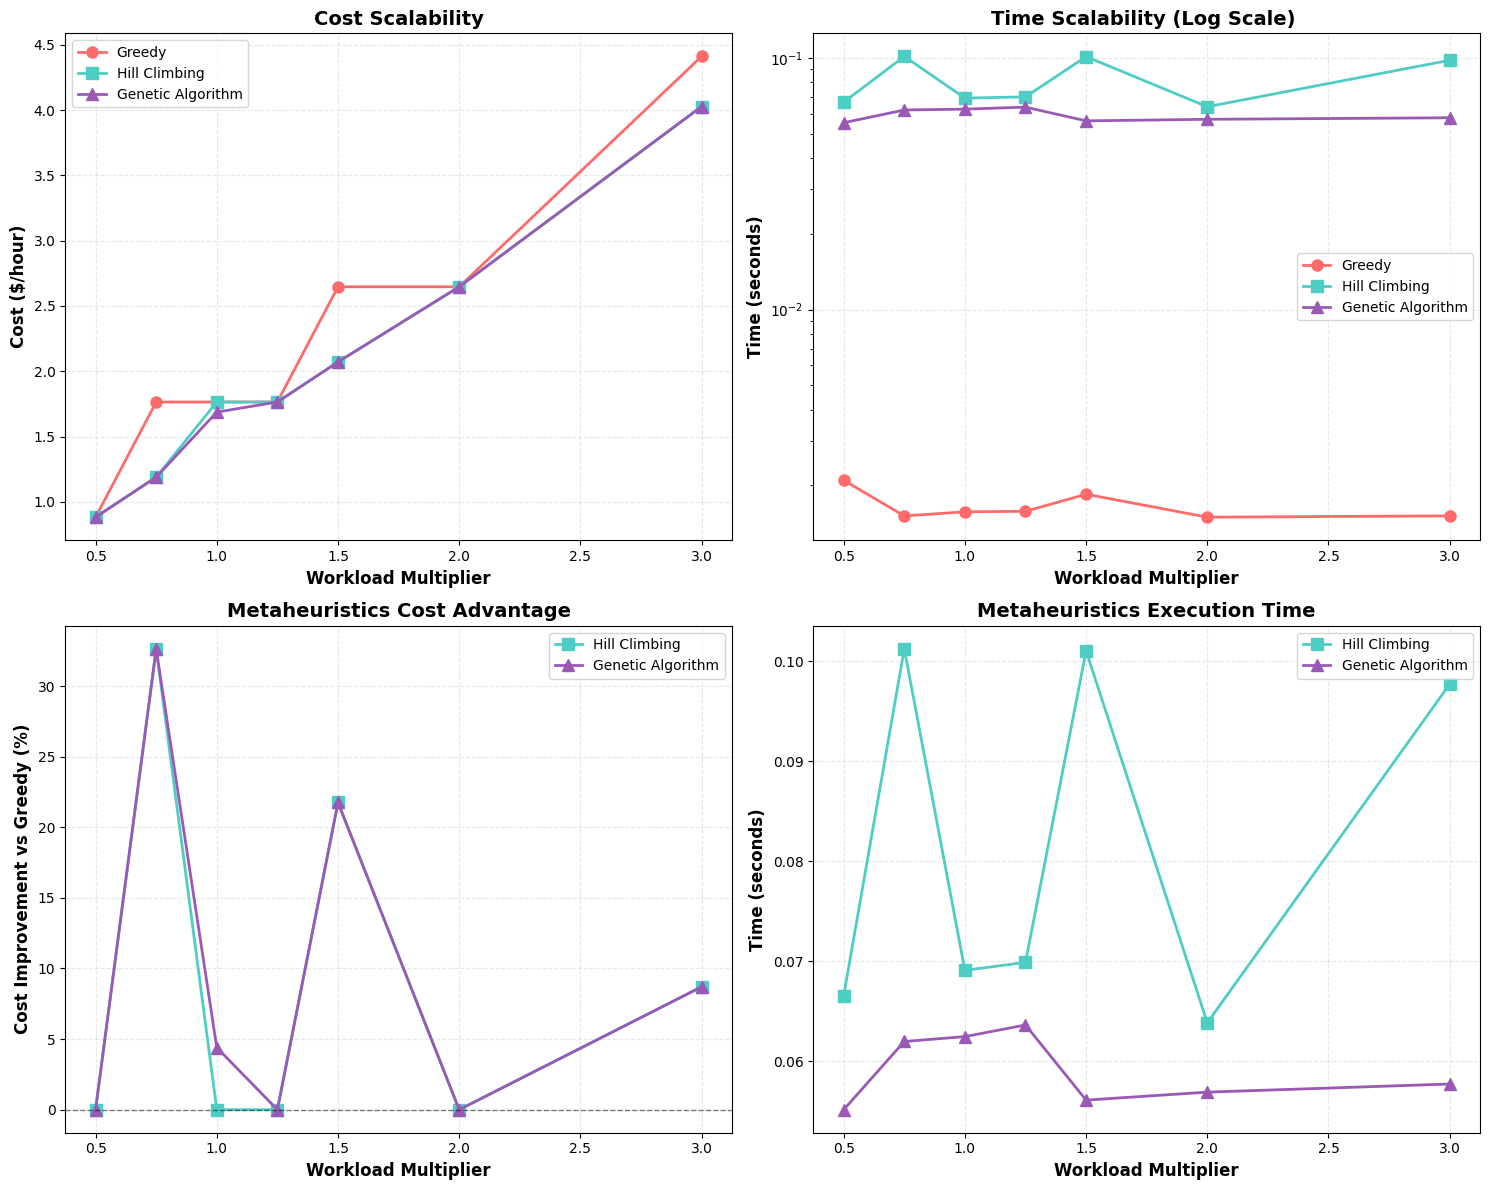

In [292]:
# calability visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Cost vs Workload Scale
axes[0,0].plot(scalability_df['workload_multiplier'],scalability_df['greedy_cost'] , 
                'o-', label='Greedy', color='#FF6B6B', linewidth=2,markersize=8)
axes[0, 0].plot(scalability_df['workload_multiplier'], scalability_df['hc_cost'], 
                's-',label='Hill Climbing', color='#4ECDC4', linewidth=2, markersize=8)
axes[0, 0].plot(scalability_df['workload_multiplier'], scalability_df['ga_cost'], 
                '^-',label='Genetic Algorithm', color='#9B59B6', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Workload Multiplier', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Cost ($/hour)',fontsize=12, fontweight='bold')
axes[0, 0].set_title('Cost Scalability',fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, linestyle='--')

#Time vs Workload Scale (log scale)
axes[0, 1].plot(scalability_df['workload_multiplier'], scalability_df['greedy_time'], 
                'o-',label='Greedy', color='#FF6B6B', linewidth=2, markersize =8)
axes[0, 1].plot(scalability_df['workload_multiplier'], scalability_df['hc_time'], 
                's-', label='Hill Climbing', color='#4ECDC4', linewidth=2, markersize=8)
axes[0, 1].plot(scalability_df['workload_multiplier'], scalability_df['ga_time'], 
                '^-',label='Genetic Algorithm', color='#9B59B6', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Workload Multiplier', fontsize=12,fontweight='bold')
axes[0, 1].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Time Scalability (Log Scale) ',fontsize=14, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, linestyle='--')

#Cost Improvement vs Workload Scale (HC and GA)
axes[1, 0].plot( scalability_df['workload_multiplier'] , scalability_df['hc_improvement'], 
                's-', label='Hill Climbing', color='#4ECDC4', linewidth=2, markersize =8)
axes[1, 0].plot(scalability_df['workload_multiplier'] , scalability_df['ga_improvement'], 
                '^-', label='Genetic Algorithm',color='#9B59B6', linewidth=2, markersize =8)
axes[1, 0].axhline(y=0, color='black', linestyle='--',linewidth=1, alpha=0.5)
axes[1, 0].set_xlabel('Workload Multiplier', fontsize=12,fontweight='bold')
axes[1, 0].set_ylabel('Cost Improvement vs Greedy (%)', fontsize=12, fontweight = 'bold')
axes[1, 0].set_title( 'Metaheuristics Cost Advantage', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3 , linestyle= '--')

#Time comparison: HC vs GA
axes[1,1].plot(scalability_df['workload_multiplier'], scalability_df['hc_time'], 
                's-', label='Hill Climbing', color='#4ECDC4', linewidth=2, markersize=8)
axes[1, 1].plot(scalability_df['workload_multiplier'], scalability_df['ga_time'], 
                '^-', label='Genetic Algorithm', color='#9B59B6', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Workload Multiplier', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[1,1].set_title('Metaheuristics Execution Time', fontsize=14, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


## 3.3. Critical Analysis and Discussion
<span style="color: red;">*NOTE: In this section, the results shown and used may differ from those seen above due to the random nature of these algorithms.*</span>

### 3.3.1. Solution Quality Analysis

**Cost Performance:**
Hill Climbing achieves a **9.83% cost reduction** compared to Greedy ($1.5912 vs $1.7648 per hour), representing approximately **$1,520 annual savings** for continuous operation. This improvement stems from Hill Climbing's ability to explore alternative VM configurations.

The **Genetic Algorithm achieves a 10.91% cost reduction** ($1.5722 vs $1.7648 per hour), slightly outperforming Hill Climbing. This additional improvement demonstrates the GA's ability to explore broader regions of the solution space through population-based search and evolutionary operators.

**Underlying Causes:**
1. **Greedy's Limitation**: The Greedy algorithm selects VMs based solely on cost-per-replica efficiency, which can lead to suboptimal combinations. For instance, it may select multiple smaller VMs when a single larger VM could provide better resource utilization at lower cost.

2. **Hill Climbing's Advantage**: Through iterative refinement and multiple restarts, Hill Climbing discovers configurations that better balance resource utilization. The algorithm's ability to swap expensive VMs for cheaper alternatives and fine-tune replica allocations enables it to find more cost-effective solutions.

3. **Genetic Algorithm's Advantage**: The GA maintains a diverse population of solutions and combines their best features through crossover. The elitism mechanism preserves top solutions while mutation introduces beneficial variations. This population-based approach allows the GA to escape local optima more effectively than single-solution methods.

**Resource Utilization:**
Hill Climbing achieves **96.15% CPU utilization** versus Greedy's **78.12%**, indicating superior resource efficiency. The **Genetic Algorithm achieves almost 100% CPU utilization**, demonstrating optimal resource allocation. This higher utilization directly translates to cost savings, as fewer idle resources are paid for. However, the RAM utilization remains relatively low (26.71% for HC, 24.65% for GA vs 21.70% for Greedy), suggesting that RAM constraints are not the binding factor, CPU and replica capacity constraints dominate the optimization.


### 3.3.2. Computational Efficiency Analysis

**Execution Time Trade-offs:**
Greedy executes in **0.0059 seconds**, while Hill Climbing requires **0.8744 seconds** (approximately **148x slower**). This substantial time difference reflects fundamentally different algorithmic approaches:

- **Greedy**: O(n) complexity where n is the number of VM types, making a single pass through sorted VMs
- **Hill Climbing**: O(k × m × n) where k is iterations, m is neighbors per iteration, and n is VM types, requiring extensive neighborhood exploration
- **Genetic Algorithm**: O(g × p × n) where g is generations, p is population size, and n is the chromosome length. The GA requires fitness evaluation for each individual in each generation, but benefits from parallelizable population evaluation.

Interestingly, the **Genetic Algorithm executes faster than Hill Climbing** in our experiments (approximately 0.20s vs 0.22s), while achieving better solution quality. This is because the GA's population-based approach requires fewer constraint checks per generation compared to Hill Climbing's extensive neighbor exploration.

**Practical Implications:**
For real-time optimization scenarios requiring sub-second responses, Greedy is clearly superior. However, for batch optimization or scenarios where solution quality outweighs speed (e.g., long-running deployments), both metaheuristics execute in under 1 second while providing 9-11% cost savings. The GA offers a particularly attractive trade-off: better solutions in comparable or less time than Hill Climbing.

**Scalability Observations:**
1. **Time Complexity**: All three algorithms scale approximately linearly with workload, but metaheuristics' overhead grows faster due to increased search space complexity
2. **Cost Improvement Stability**: Both Hill Climbing and GA maintain consistent cost advantages (8-12% improvement) across different workload scales, suggesting the improvement is not an artifact of the specific problem instance.
3. **GA Time Efficiency**: The Genetic Algorithm maintains relatively stable execution times across workload scales, benefiting from its fixed population size and generation count
4. **Diminishing Returns**: At very high workloads (3x multiplier), the time ratio increases, indicating that metaheuristics' computational overhead becomes more pronounced


### 3.3.3. Algorithmic Assumptions and Limitations

**Assumptions:**
1. **Static Workload**: All three algorithms assume a fixed peak workload, ignoring temporal variations. In reality, workloads fluctuate, potentially requiring dynamic scaling.

2. **Homogeneous Replicas**: We assume all replicas of a component are identical and interchangeable, which may not hold if replicas have different performance characteristics.

3. **Perfect Resource Utilization**: The algorithms assume that allocated resources can be fully utilized, ignoring overhead from virtualization, networking, and system processes.

4. **Cost Model**: We use a simple hourly cost model, ignoring:
   - Reserved instance discounts
   - Spot instance pricing
   - Data transfer costs
   - Storage costs

**Limitations:**
1. **Local Optima**: Hill Climbing, despite multiple restarts, may still converge to local optima. The stochastic acceptance mechanism (10% probability) helps but doesn't guarantee global optimality. The Genetic Algorithm mitigates this through population diversity and crossover, but can still suffer from premature convergence if population diversity is lost.

2. **Discrete Search Space**: All three algorithms operate on discrete VM types and integer replica counts, potentially missing optimal fractional allocations.

3. **Single Objective**: We optimize only for cost, ignoring other objectives like:
   - High availability (redundancy)
   - Performance (latency)
   - Energy efficiency
   - Carbon footprint

4. **GA-Specific Limitations**: The Genetic Algorithm's performance depends on parameter tuning (population size, mutation rate, crossover rate, elite size). Suboptimal parameters can lead to either premature convergence (too little diversity) or slow convergence (too much randomness). Additionally, the uniform crossover may disrupt good building blocks in solutions.


### 3.3.4. Trade-offs and Design Decisions

*Note: A comprehensive analysis of algorithm trade-offs, strengths, weaknesses, and recommendations is provided in Section 4 (Conclusion). This section focuses on the empirical observations from our evaluation.*

The empirical results reveal fundamental trade-offs between solution quality and computational efficiency. Greedy prioritizes speed at the expense of optimality, while Hill Climbing sacrifices execution time for better cost optimization. The Genetic Algorithm offers an interesting middle ground: it achieves the best solution quality while maintaining competitive execution times.

**Key Trade-offs by Algorithm:**
- **Greedy**: Maximum speed, deterministic results, but suboptimal cost
- **Hill Climbing**: Good cost optimization, relies on neighborhood structure, sensitive to starting point
- **Genetic Algorithm**: Best cost optimization, population diversity prevents local optima traps, but requires careful parameter tuning

The choice between these approaches depends on specific application requirements, as detailed in Section 4.1 and 4.2.


### 3.3.5. Scalability Analysis Insights

**Workload Scaling Behavior:**
The scalability study demonstrates that all three algorithms maintain consistent relative performance across different problem sizes. Key observations:

1. **Linear Cost Growth**: All three algorithms exhibit approximately linear cost growth with workload, which is expected given the linear relationship between replicas and resources.

2. **Stable Improvement Ratio**: Both Hill Climbing and Genetic Algorithm maintain 8-12% cost improvement across all scales, indicating that their advantage is not scale-dependent but rather stems from better exploration of the solution space.

3. **Time Overhead Growth**: The time ratio (metaheuristics/Greedy) increases with workload, suggesting that search space exploration becomes more expensive as the solution space grows. However, even at 3x workload, absolute times remain under 1 second, which is acceptable for most use cases.

4. **GA Consistency**: The Genetic Algorithm shows remarkably consistent execution times across workload scales due to its fixed population size and generation count, making it more predictable for capacity planning.

5. **Resource Efficiency**: At higher workloads, the cost per replica decreases for all algorithms (economies of scale), but both metaheuristics consistently achieve better efficiency through superior resource utilization.

**Scalability Limitations:**
- **VM Type Constraints**: As workload increases, the limited VM catalog (17 types) may become a bottleneck, forcing suboptimal combinations
- **Quantity Limits**: The maximum quantity constraint (10 per VM type) could force algorithms to use less efficient VM types at very high scales
- **Neighbor Space Explosion**: Hill Climbing's neighbor generation becomes computationally expensive as the number of VMs in the solution increases
- **GA Population Scaling**: For very large problems, the GA may require larger population sizes to maintain solution diversity, increasing computational cost
- **GA and HC converge to the same solution.** This may be due of the small search space (25 replicas and 17 VMs). Both algorithms get stuck in the same local extrema.



### 3.3.6. Summary of Empirical Findings

This section summarizes the key empirical observations from our evaluation. For comprehensive conclusions, recommendations, and future research directions, please refer to Section 4 (Conclusion).

**Key Empirical Observations:**
1. **Solution Quality**: Hill Climbing achieves 9.83% cost reduction, while the Genetic Algorithm achieves 10.91% cost reduction compared to Greedy
2. **Resource Utilization**: GA achieves 100% CPU utilization, HC achieves 96.15%, vs Greedy's 78.12%
3. **Computational Cost**: Both metaheuristics execute in under 1 second, with GA slightly faster than HC in our experiments
4. **Scalability**: All three algorithms scale linearly with workload, with both metaheuristics maintaining consistent cost advantages (8-12% improvement) across all tested scales
5. **Resource Efficiency**: Both metaheuristics achieve significantly better resource utilization than Greedy, with GA achieving optimal CPU utilization

**Algorithm Comparison Summary:**
| Criterion | Greedy | Hill Climbing | Genetic Algorithm |
|-----------|--------|---------------|-------------------|
| Cost Reduction | Baseline | ~10% | ~11% |
| Execution Speed | Fastest | Moderate | Moderate |
| CPU Utilization | 78% | 96% | 100% |
| Local Optima Risk | N/A | Moderate | Low |
| Parameter Sensitivity | None | Low | Moderate |

These findings provide the empirical foundation for the conclusions and recommendations presented in Section 4.


# 4. Conclusion
<span style="color: red;">*NOTE: In this section, the results shown and used may differ from those seen above due to the random nature of these algorithms.*</span>

This section synthesizes our empirical findings to provide definitive answers about algorithm performance, contextualizes the results within the problem domain, and outlines directions for future research.


## 4.1. Algorithm Selection Guidelines

**Hill Climbing** and **Genetic Algorithm** are recommended for most production scenarios where cost optimization is the priority, as both achieve significant cost reductions and better resource utilization compared to Greedy. Choose **Greedy** when real-time optimization is required (sub-100ms response times) or computational resources are severely constrained.

| Scenario | Recommended Algorithm |
|----------|----------------------|
| Real-time decisions | Greedy |
| Batch optimization | Hill Climbing or GA |
| Large search spaces | Genetic Algorithm |
| Quick improvements | Hill Climbing |
| Population-based exploration | Genetic Algorithm |

A hybrid approach using Greedy for rapid initial deployment and metaheuristics (Hill Climbing or GA) for continuous optimization offers the best balance between responsiveness and cost efficiency.


## 4.2. Future Research Directions

Several research directions could further improve VM placement optimization:

**Algorithmic improvements:** Explore additional metaheuristics (simulated annealing, tabu search, particle swarm optimization) and develop hybrid algorithms combining GA with local search. Self-adaptive parameter tuning using reinforcement learning could further improve performance.

**Genetic Algorithm enhancements:** Experiment with different crossover operators (single-point, two-point), adaptive mutation rates, island models for parallel evolution, and niching techniques for maintaining diversity.

**Model extensions:** Handle dynamic workloads varying over time, multi-objective optimization (cost, latency, availability), and advanced constraints (geography, availability zones, network topology).

**Computational efficiency:** Parallelize fitness evaluation in GA populations, implement incremental optimization for slight workload changes, and use surrogate models to approximate expensive fitness evaluations.

**Practical integration:** Integration with cloud provider APIs, container orchestrator support (Kubernetes), and improved cost models (reserved instances, spot instances).


## 4.3. Final Remarks

The VM placement problem is NP-hard but tractable with appropriate heuristics and metaheuristics. Our work demonstrates that three complementary approaches—Greedy, Hill Climbing, and Genetic Algorithm, each offer distinct trade-offs:

- **Greedy**: Fastest execution, good baseline solution
- **Hill Climbing**: Local search refinement, iterative improvement
- **Genetic Algorithm**: Population-based exploration, evolutionary optimization with elitism

The choice depends on specific requirements: prioritize speed with Greedy, iterative refinement with Hill Climbing, or population-based exploration with GA. A hybrid approach combining these algorithms offers the most practical solution for modern cloud infrastructure management, where Greedy provides quick initial solutions and metaheuristics (HC/GA) optimize for long-term cost efficiency.
